# Regressão Logística utilizando PySpark

Iniciando um estudo em regressão logística utilizando um dataset conhecido como o titanic

### Iniciando as configurações do Spark

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"
findspark.init('spark-2.4.4-bin-hadoop2.7')

## Importação das Bibliotecas

In [19]:
import pyspark

from pyspark.sql import SparkSession

from pyspark.ml.feature import VectorAssembler, VectorIndexer, OneHotEncoder, StringIndexer

import matplotlib.pyplot as plt
import seaborn as sns 

## Criação de uma sessão spark e leitura da base

In [4]:
spark = SparkSession.builder.appName('my_project').getOrCreate()

In [5]:
PATH = '/content/drive/MyDrive/Colab Notebooks/Estudos/Spark/Logistic_Regression/base/titanic.csv'
data = spark.read.csv(PATH, header = True, inferSchema = True)
data.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [6]:
data.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

## Alterações e Análises na Base

### Selecionando e removendos valores nulos ou NAN

In [7]:
my_cols = data.select(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'])

final_data = my_cols.na.drop()
final_data.show(10)

+--------+------+------+----+-----+-----+-------+--------+
|Survived|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|
+--------+------+------+----+-----+-----+-------+--------+
|       0|     3|  male|22.0|    1|    0|   7.25|       S|
|       1|     1|female|38.0|    1|    0|71.2833|       C|
|       1|     3|female|26.0|    0|    0|  7.925|       S|
|       1|     1|female|35.0|    1|    0|   53.1|       S|
|       0|     3|  male|35.0|    0|    0|   8.05|       S|
|       0|     1|  male|54.0|    0|    0|51.8625|       S|
|       0|     3|  male| 2.0|    3|    1| 21.075|       S|
|       1|     3|female|27.0|    0|    2|11.1333|       S|
|       1|     2|female|14.0|    1|    0|30.0708|       C|
|       1|     3|female| 4.0|    1|    1|   16.7|       S|
+--------+------+------+----+-----+-----+-------+--------+
only showing top 10 rows



In [9]:
final_data_pandas = final_data.toPandas()
final_data_pandas.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Análises exploratórias

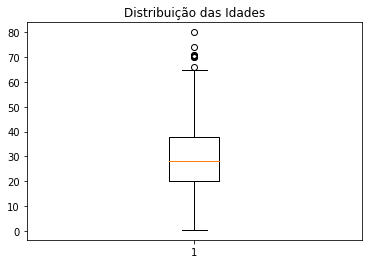

In [10]:
plt.boxplot(final_data_pandas['Age'])
plt.title('Distribuição das Idades')
plt.show()

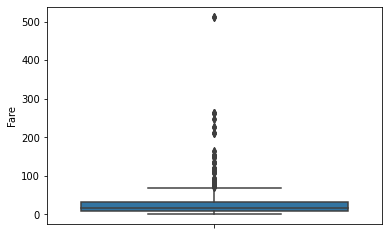

In [18]:
sns.boxplot(y = final_data_pandas['Fare'], )
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


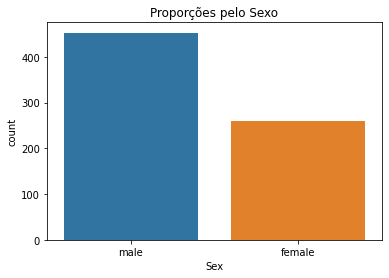

In [13]:
sns.countplot(final_data_pandas['Sex'])
plt.title('Proporções pelo Sexo')
plt.show()

### Tratando as colunas categóricas

In [20]:
gender_indexer = StringIndexer(inputCol = 'Sex', outputCol = 'SexIndex')
gender_encoder = OneHotEncoder(inputCol = 'SexIndex', outputCol = 'SexVec')

In [21]:
embark_indexer = StringIndexer(inputCol = 'Embarked', outputCol = 'EmbarkIndex')
embark_encoder = OneHotEncoder(inputCol = 'EmbarIndex', outputCol = 'EmbarkVec')

In [22]:
inputCols = ['Pclass', 'SexVec', 'Age', 'SibSp', 'Parch', 'Fare', 'EmbarkVec']
assembler = VectorAssembler(inputCols = inputCols, outputCol = 'features')